In [61]:
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, mannwhitneyu

sns.set('talk', rc={'figure.figsize': (18, 10)})
pd.options.display.max_columns = None

## Загрузка и обзор данных

### Загрузка

In [62]:
df = pd.read_csv("example_data.gz")

In [63]:
df.sample(10)

,user_id,timestamp,event
586519,6481f94c53863c64f7875121d4608499,2021-02-21 16:05:32.942933506,landing
179208,a380e259cacbf51f948517c3b753cec2,2021-01-16 21:41:03.558650667,login
968900,070a58733d45aa83c5f268c836cdc484,2021-03-30 06:20:43.997210338,landing
905039,07fc0fb8b8581fd1152777d86f98704f,2021-03-22 08:51:29.616368625,login
279278,6fcb331ea5839c8ba951b10003779260,2021-01-25 13:01:01.404270333,main
243215,fc79a2086a042fda3700ce9a91e0e657,2021-01-22 10:08:21.767512555,landing
888515,8b09faeb867684b769af520b1f47a50f,2021-03-21 00:18:59.092891732,landing
340360,4ff7ca0aab677976ab730ea55baae334,2021-01-31 00:18:58.531922409,landing
943968,10cff607322f1845a088e097dad49537,2021-03-27 10:03:07.837335138,main
750689,cdb413c8015147dc2985c563d8ad1b4a,2021-03-07 12:39:44.120452600,main


### Обзор данных

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040171 entries, 0 to 1040170
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   user_id    1040171 non-null  object
 1   timestamp  1040171 non-null  object
 2   event      1040171 non-null  object
dtypes: object(3)
memory usage: 23.8+ MB


Всего 5 типов событий посещений страниц, причем 2 из них — это старая и новая версия страницы регистрации.
Это не совсем очевидно и может быть некорректно, но будем счатать, что:
1. Посещение страницы login является признаком того, что регистрация пройдена и пользователь логинится.
2. Посещение страницы main может быть произведено и незарегистрировавшимся пользователем.
3. Пользователь приобретает услуги/приносит ценность компании посещая страницу login. Это же событие сипользуем, чтобы "засчитать" пользователю активность в этот день

In [65]:
df["event"].value_counts()

landing             389350
main                336030
login               257227
registration         51943
registration_new      5621
Name: event, dtype: int64

In [66]:
df["timestamp"].value_counts()

2021-03-19 08:53:22.740489453    12
2021-02-23 12:29:09.672036235     9
2021-01-12 22:15:05.062824176     9
2021-01-29 02:15:25.086335450     9
2021-02-26 03:41:42.065887597     8
                                 ..
2021-02-01 22:12:53.792808749     1
2021-02-01 22:13:15.982570769     1
2021-02-01 22:13:17.837712281     1
2021-02-01 22:13:22.935300640     1
2021-04-07 13:20:34.394602584     1
Name: timestamp, Length: 938229, dtype: int64

In [67]:
df["user_id"].value_counts()

c9be7da3b5c975cc2795f15d45f0390a    5130
e7dcf0579c9e5cd13e881e44510d03a6    2595
6259ded656abc545d040af215e4ddcc6    2071
ffc3b3cc40797a17766c625212748fe5    1465
41b34f6d4c55db356afafff81abccd36    1343
                                    ... 
4c510423d528f39c2e5412c5212a866c       1
91832450f69aba633ede0e3136837155       1
b2aa47be56897fe26cbeba767d68e554       1
bb9fe076de635adccf8254666f8dea3e       1
148870bfa84777898359aaa8e120a373       1
Name: user_id, Length: 261130, dtype: int64

In [68]:
df["timestamp"] = pd.to_datetime(df["timestamp"])

Text(0, 0.5, 'Количество событий')

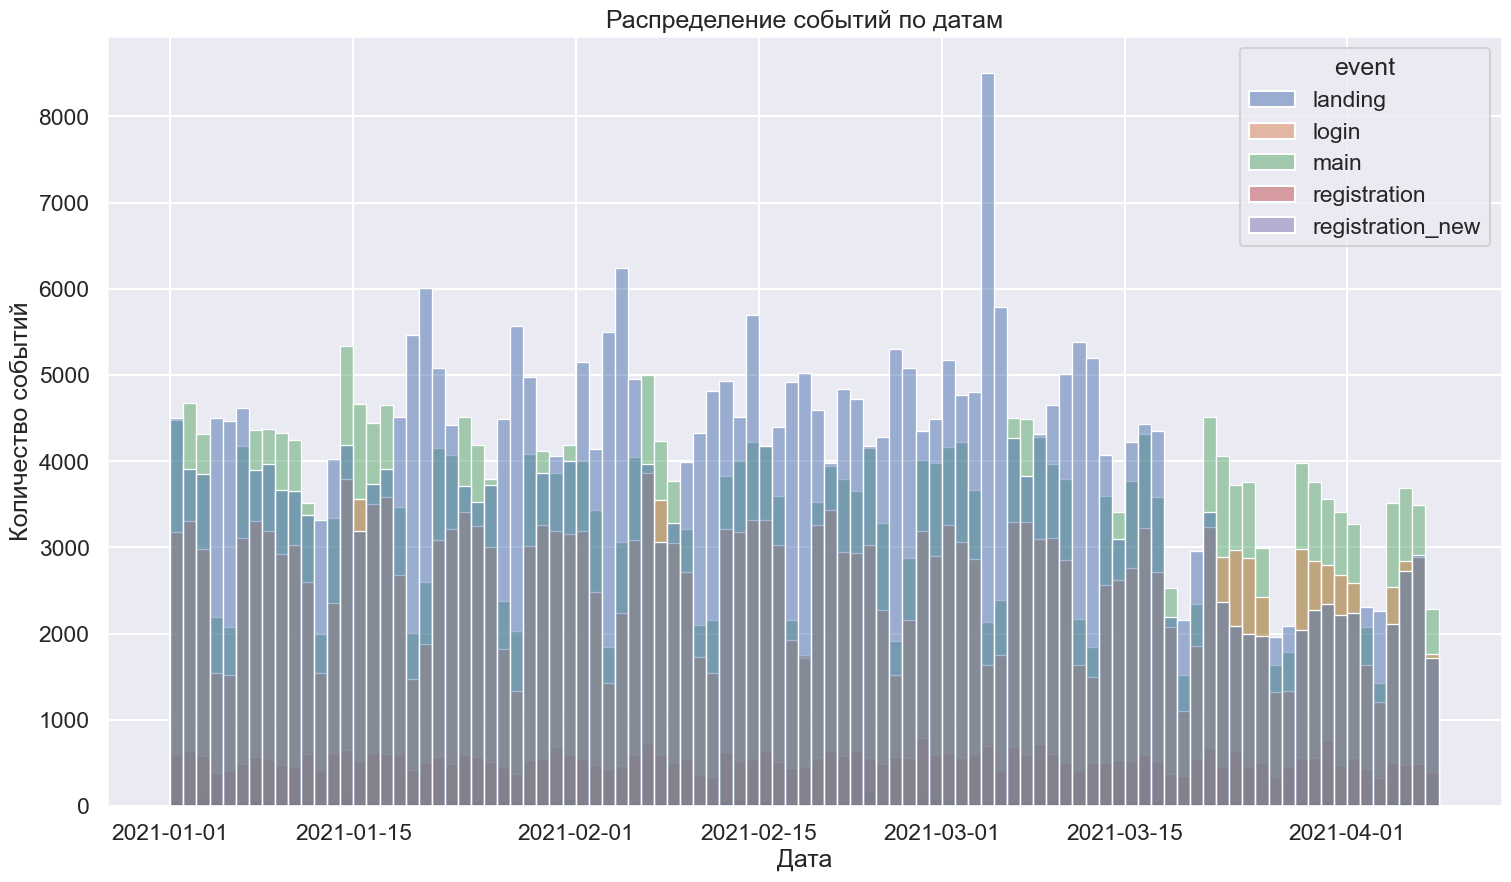

In [70]:
ax = sns.histplot(
    data=df,
    x="timestamp",
    hue="event",
    binwidth=1
)
ax.set_title("Распределение событий по датам")
ax.set_xlabel("Дата")
ax.set_ylabel("Количество событий")

Text(0, 0.5, 'Количество событий')

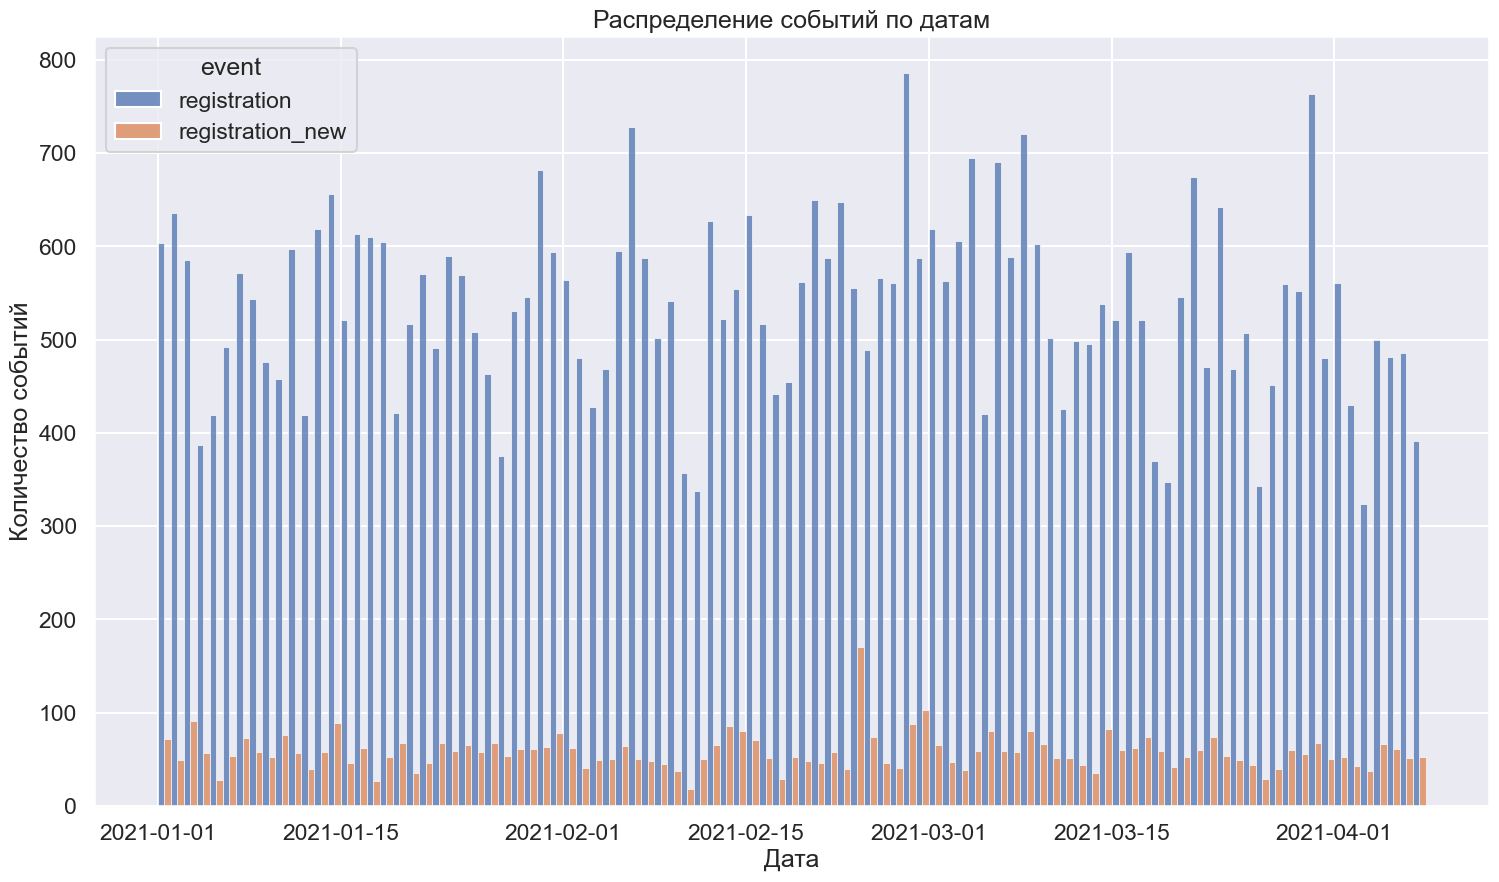

In [71]:
ax = sns.histplot(
    data=df.loc[df["event"].isin(["registration", "registration_new"])],
    x="timestamp",
    hue="event",
    multiple="dodge",
    binwidth=1
)
ax.set_title("Распределение событий по датам")
ax.set_xlabel("Дата")
ax.set_ylabel("Количество событий")

Проверим порядок событий и возможность их пересечений.

In [73]:
df_grouped = df.groupby(["user_id", "event"])[["timestamp"]].count().reset_index()

In [74]:
df_grouped = df_grouped.pivot(index="user_id", columns="event", values="timestamp").fillna(0)

In [75]:
df_grouped.sample(5)

event,landing,login,main,registration,registration_new
user_id,,,,,
bfdb7df762a1cee2a1821d1c4801a923,0.0,3.0,0.0,0.0,4.0
428bc66b3e682a494ca6908b20867ba0,4.0,0.0,0.0,0.0,0.0
6e84016283f84e6b03bf44044d36572b,0.0,0.0,0.0,2.0,0.0
e3c2be5ac8d7b3b1ef8f0035f0e12d8d,1.0,0.0,0.0,0.0,0.0
233f8a671ee76d819d4e24bd5f7f49df,1.0,0.0,0.0,0.0,0.0


Один пользователь не посещал 2 разные страницы регистрации

In [76]:
df_grouped.loc[
    (df_grouped["registration"] > 0)
    & (df_grouped["registration_new"] > 0)
    ].shape

(0, 5)

Пользователи могут посещать главную страницу без регистрации

In [77]:
df_grouped.loc[
    (df_grouped["login"] == 0)
    & (df_grouped["main"] > 0)
    ].shape

(8938, 5)

Пользователи могут попасть на страницу регистрации, минуя все остальные страницы

In [78]:
df_grouped.loc[
    (df_grouped["landing"] == 0)
    & (df_grouped["main"] == 0)
    & (df_grouped["login"] == 0)
    & (
            (df_grouped["registration"] > 0)
            | (df_grouped["registration_new"] > 0)
    )
    ].shape

(9448, 5)

Пользователи попасть на страницу логина не побывав на странице регистрации

In [79]:
df_grouped.loc[
    (df_grouped["login"] > 0)
    & (df_grouped["registration"] == 0)
    & (df_grouped["registration_new"] == 0)
    ].shape

(38904, 5)

Пользователи попасть на главную страницу не побывав на странице регистрации

In [80]:
df_grouped.loc[
    (df_grouped["main"] > 0)
    & (df_grouped["registration"] == 0)
    & (df_grouped["registration_new"] == 0)
    ].shape

(32297, 5)

### Что будем делать?

Поскольку метрик доходности пользователей с разных страниц регистрации нет, будем считать их равнозначными.
Тогда определяющей характеристикой для страницы регистрации будет конверсия registration->login. Будем считать, что регистрация прошла успешно, если пользователь в окно 24 часа после регистрации пеерходил на страницу login.
Также сравним "ценность" пользователей оценивая их LT. При условии равенства ARPU это будет эквиваленту сравнения LTV.

## Конверсия registration->login


In [81]:
df.head(3)

,user_id,timestamp,event
0,148870bfa84777898359aaa8e120a373,2021-01-01 00:00:01.000000000,landing
1,ac3948ea43cb39cdc4e739004d252d0b,2021-01-01 00:00:01.445020335,landing
2,48a0df50d7ed1fcaaddf742b828b85e5,2021-01-01 00:00:10.566157670,login


Берем только те события, которые нас интересуют

In [82]:
df_registration = df.loc[df["event"].isin(["login", "registration", "registration_new"])].copy()

Для поиска следующей даты логина выносим ее в отдельный столбик.

In [83]:
df_registration["login_timestamp"] = pd.to_datetime("2099-01-01")
df_registration.loc[df_registration["event"] == "login", "login_timestamp"] = df_registration["timestamp"]
df_registration["login_timestamp"] = df_registration["login_timestamp"].astype(int)

In [84]:
df_registration.set_index("timestamp", inplace=True)

In [85]:
df_registration.sample(5)

,user_id,event,login_timestamp
timestamp,,,
2021-01-26 13:28:10.760851277,388ee4de60ae33ea56a8695518e8cda7,registration_new,4070908800000000000
2021-01-09 09:30:26.393687928,1d5c4ac3a9344e266c7d2ad6656305f8,login,1610184626393687928
2021-03-03 18:33:40.729762002,55ff1ef3c7063724b4015e7a098bbe52,login,1614796420729762002
2021-02-06 16:36:39.851926934,9f5776d8ce249ba82a19acaaae316135,login,1612629399851926934
2021-04-02 19:47:59.194316483,dd8e636b92f50ae35dc63fe582fdc4f7,registration,4070908800000000000


Определяем для каждого события в окне в 1 день дату близжайшего перехода на страницу login

In [86]:
df_registration_window = df_registration.groupby(["user_id"])["login_timestamp"].rolling(window="1D").min().reset_index(
    level=0)

In [87]:
df_registration_window.rename(columns={"login_timestamp": "first_login_timestamp"}, inplace=True)

In [88]:
df_registration_window.sample(5)

,user_id,first_login_timestamp
timestamp,,
2021-03-21 02:32:17.406612439,f373d408116f6ab58f207e80ce39cbca,1.616271e+18
2021-02-27 22:10:42.036973025,356585e95e970d3d19529fd8b0840653,1.614418e+18
2021-01-06 16:28:44.425187467,e96750243d56b3cb6fd9c7ff62a491ff,1.609951e+18
2021-03-07 05:45:42.822147441,5adc4e821e6f9ef33eae9d32033e6120,1.615077e+18
2021-01-23 19:02:57.195024358,d30ef0c29028d05d3577752633378d22,1.611406e+18


In [89]:
df_registration = df_registration.join(df_registration_window["first_login_timestamp"])

In [90]:
df_registration["first_login_timestamp"] = pd.to_datetime(df_registration["first_login_timestamp"])
df_registration["login_timestamp"] = pd.to_datetime(df_registration["login_timestamp"])

In [91]:
df_registration.sample(5)

,user_id,event,login_timestamp,first_login_timestamp
timestamp,,,,
2021-02-01 05:28:44.939923152,34339d909095c1b7cbeda77cb1745ce3,login,2021-02-01 05:28:44.939923152,2021-02-01 05:28:44.939923200
2021-03-18 04:58:39.710925034,cfc8589410020b2478acbfaa9aeaf023,login,2021-03-18 04:58:39.710925034,2021-03-17 07:21:51.176779776
2021-02-24 20:13:08.421663963,af08627e2cd8982168a7b316ef08af6b,login,2021-02-24 20:13:08.421663963,2021-02-24 20:06:03.130308096
2021-03-21 07:20:28.902160085,892e75b8264ee694e63fd08cbeefcb84,login,2021-03-21 07:20:28.902160085,2021-03-21 05:56:17.673113344
2021-02-07 09:31:27.543973185,03b8665ea635abc957b03b24d2581c2e,login,2021-02-07 09:31:27.543973185,2021-02-07 06:20:56.943464192


Оставляем только события регистрации

In [92]:
df_registration = df_registration.loc[
    (df_registration["event"].isin(["registration", "registration_new"]))
].copy()

In [93]:
df_registration.sample(5)

,user_id,event,login_timestamp,first_login_timestamp
timestamp,,,,
2021-01-24 17:49:26.206133804,53cf3cc5028ba2557edda0ae904a9104,registration,2099-01-01,2099-01-01 00:00:00.000000000
2021-02-26 03:50:49.666182516,aaf7f0a72ef8812cc19e4d1773cd09b9,registration,2099-01-01,2099-01-01 00:00:00.000000000
2021-02-05 00:23:44.654682138,8a0b12fb132f3c733d58f7eeb1223d97,registration,2099-01-01,2099-01-01 00:00:00.000000000
2021-02-04 22:33:31.140578530,432041e959a741be4a8acd6f4f2c539f,registration,2099-01-01,2021-02-04 22:27:58.457845248
2021-03-22 22:42:21.303263201,1d5d425e48b195ffda6e5df92cc94149,registration,2099-01-01,2021-03-22 22:00:50.348235776


In [94]:
df_registration["conversion"] = df_registration["first_login_timestamp"] < pd.to_datetime('2099-01-01')
df_registration = df_registration.reset_index()

Пользователь мог приходить на страницу регистрации как до успеной регистрации, так и после. Нам нужно найти первую успешную попытку регистрации, если она была. Если нет — взять первую не успешную.
Можно бы и не брать даты, а просто посмотреть итоговый факт зарегистрировался или нет, но тогда не получится посмотреть как менялась конверсия по дням.

In [95]:
df_registration_true = df_registration.loc[df_registration["conversion"]].groupby(["user_id", "event"])[
    ["timestamp"]].min().reset_index(level=1)
df_registration_false = df_registration.loc[~df_registration["conversion"]].groupby(["user_id", "event"])[
    ["timestamp"]].min().reset_index(level=1)

In [96]:
df_registration_true["conversion"] = True
df_registration_false["conversion"] = False

In [97]:
df_registration = pd.concat(
    [df_registration_true,
     df_registration_false.loc[~df_registration_false.index.isin(df_registration_true.index)]]
)

In [98]:
df_registration.sample(5)

,event,timestamp,conversion
user_id,,,
f9a26bcc2d212f7a68229d4716f17461,registration,2021-01-21 22:47:09.650172245,False
d558b07650a5a0af170a37c25433a8fe,registration,2021-02-26 04:04:56.337893067,False
58eab05374cb7cced329c81b3ca48387,registration,2021-01-09 09:25:26.074277531,False
11ee4ac20aba3004288d11ae555b394e,registration,2021-02-25 22:04:58.608769233,False
3ea196ecdd33cf3bd9ad7e8a2014442c,registration,2021-02-12 02:23:25.121932272,True


### Средние и тест

In [99]:
df_registration.groupby(["event"])[["conversion"]].mean()

,conversion
event,
registration,0.269042
registration_new,0.281102


In [100]:
df_registration.groupby(["event"])[["conversion"]].count()

,conversion
event,
registration,24078
registration_new,2540


Данные у нас категориальные (зарегался или нет), наблюдений много (более 2500 для тестовой группы) так что смело используем t-критерий Стюдента.
Пороговое значение для p-value не было обговорено, поэтому примем его за 0.05.

In [101]:
ttest_ind(
    df_registration.loc[df_registration["event"] == "registration", "conversion"],
    df_registration.loc[df_registration["event"] == "registration_new", "conversion"]
)

Ttest_indResult(statistic=-1.3018053328059904, pvalue=0.1929942068751217)

Разница в конверссии не статзначима. Данные не позволяют отбросить гипотезу о равенстве средних.

### График конверсии

Посмотрим, как конверии менялись в течении эксперимента. Эти данные помогут в планировании последующих эксперимантов.

In [102]:
df_registration = df_registration.sort_values("timestamp")

df_registration["one"] = 1
df_registration[["current_reg", "denominator"]] = df_registration.groupby(["event"])[["conversion", "one"]].cumsum()

df_registration["current_conversion"] = df_registration["current_reg"] / df_registration["denominator"]

Text(0, 0.5, 'Конверсия, доли')

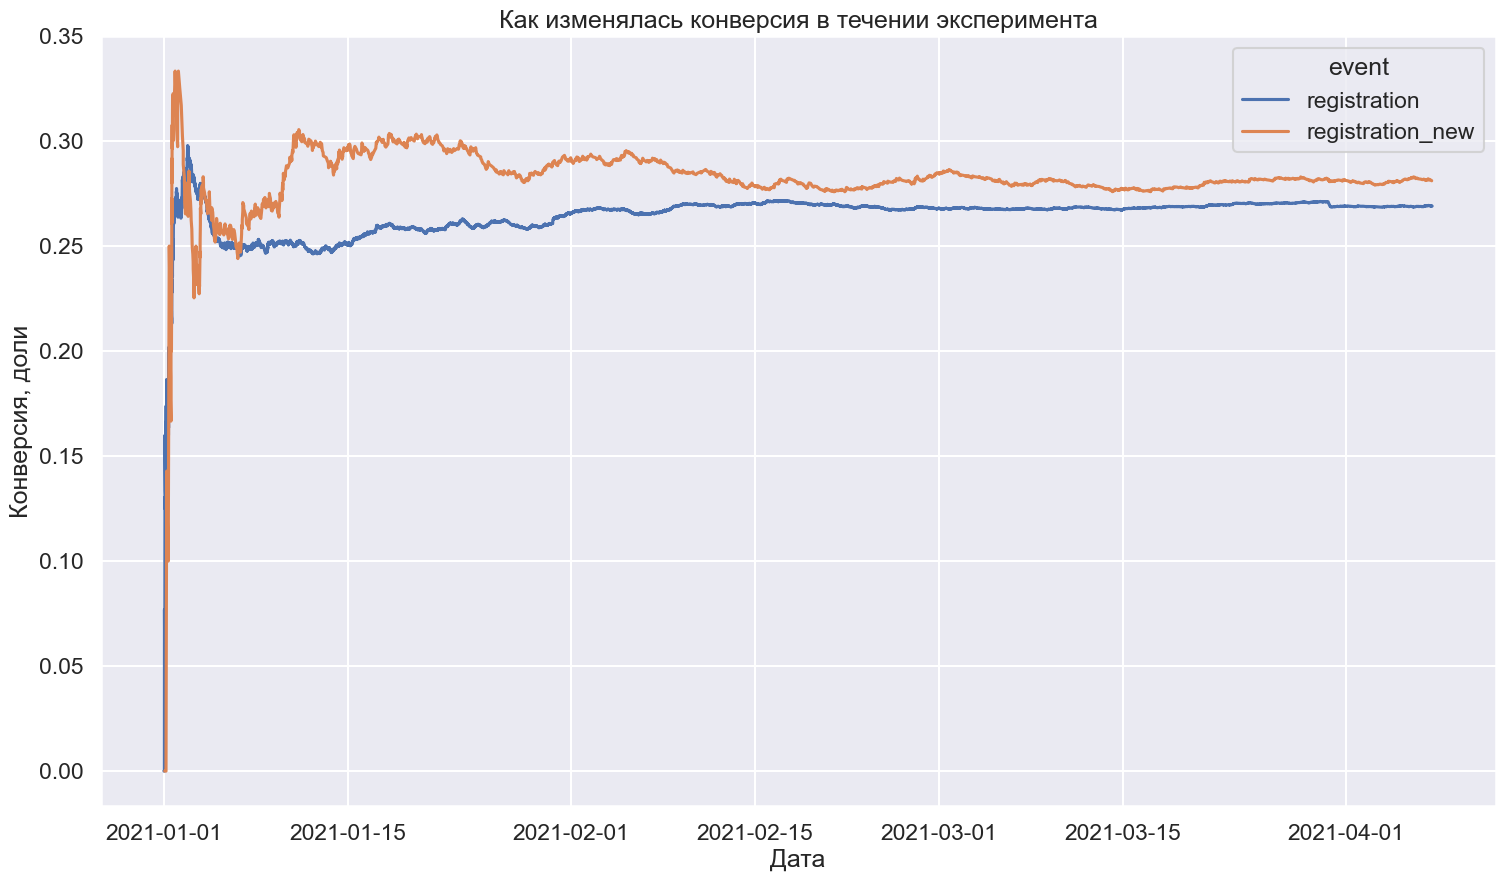

In [103]:
ax = sns.lineplot(
    data=df_registration,
    x="timestamp",
    y="current_conversion",
    hue="event"
)
ax.set_title("Как изменялась конверсия в течении эксперимента")
ax.set_xlabel("Дата")
ax.set_ylabel("Конверсия, доли")

Выходит хороший график, значения конверсий стабилизаруются на одном уровне. Какого-либо дрейфа не происходит. Так что тут нет пространства для подозрений, что в течении эксперимента что-то изменилось.

## LT пользователей

Теперь посмотрим на качество регистраций. Считаем, что наш сервис используется ежедневно. Поскольку финансовых данных нет, считаем, что ARPU за день равны для регистраци с новой и старой версии страницы.
Каких-либо графиков расчета retention строить не будем, а так же будем оценивать LT по DAU, а не по последнему дню активности. В таком случае LT когорты можно посчитать как сумму DAU этой когорты с первого дня до потери последнего пользователя(и в рамках разумного окна), разделенная на размер когорты. Такой формат LT представляет собой "человеко-дни" умножив которые на ARPU можно получить LTV.

In [104]:
df_registration = df_registration.reset_index()
df_registred_users = df_registration.loc[
    df_registration["conversion"],
    ["user_id", "event", "timestamp"]
]

In [105]:
df_registred_users["timestamp"] = df_registred_users["timestamp"].dt.date

In [106]:
df_registred_users.rename(columns={
    "event": "reg_type",
    "timestamp": "reg_date"
}, inplace=True)

In [107]:
df_registred_users.sample(5)

,user_id,reg_type,reg_date
4159,3bc7c5312cc8712149ad451a1f5f29bd,registration_new,2021-01-14
4331,6386985e9711e4d938cb76fd9ba02256,registration,2021-01-15
369,499e584871521d93b026f6689711fb22,registration,2021-01-02
26093,3099a2cc871b84a7a5bc62f2db47da7b,registration_new,2021-04-05
1607,2d57d015dc888a1e90c0a89a3cd33809,registration,2021-01-06


In [108]:
df_activity = df.copy()
df_activity["activity_date"] = df_activity["timestamp"].dt.date
df_activity = df_activity.groupby(["user_id", "activity_date"])[["event"]].count().reset_index()

In [109]:
df_activity = df_activity.merge(df_registred_users, on="user_id", how="inner")
df_activity = df_activity.loc[df_activity["activity_date"] >= df_activity["reg_date"]]

In [110]:
df_activity["activity_day"] = (df_activity["activity_date"] - df_activity["reg_date"]).dt.days + 1

In [111]:
df_activity.sample(5)

,user_id,activity_date,event,reg_type,reg_date,activity_day
9839,7329ea7de6ad2ab3ce5179c5eb93c877,2021-02-03,8,registration,2021-02-03,1
5876,4451dc063174d1773e3ddd6884b433dc,2021-01-09,15,registration,2021-01-09,1
16169,c04a29197ad9d342934d69524c5b2405,2021-02-25,2,registration,2021-02-21,5
19474,e66886e00d8b2b56bc56dbd66db993da,2021-04-01,1,registration_new,2021-03-11,22
4083,2edc5bae5fb4f3f45f75c69537893f4e,2021-02-23,3,registration,2021-01-15,40


In [112]:
df_activity["activity_day"].quantile(0.80)

23.0

In [113]:
df_activity["activity_date"].max()

datetime.date(2021, 4, 7)

Отсечем когорты, которые зарегистрировались позднее, чем за 23 дней до последних данных, когорые мы получили — по ним статистика будет не полная.

In [114]:
df_activity = df_activity.loc[df_activity["reg_date"] > (df_activity["activity_date"].max() - pd.Timedelta(23, 'days'))]

In [115]:
df_activity.sample(5)

,user_id,activity_date,event,reg_type,reg_date,activity_day
2532,19f4fa960a7cce11c4182c3d047d87c6,2021-04-05,7,registration,2021-04-05,1
21209,f927da5efc1e63a24adc946561a21c9d,2021-03-21,2,registration,2021-03-20,2
7552,56ba8a28cebd32bf9f23d9acef6b8326,2021-03-30,7,registration,2021-03-26,5
401,03388826e73a6f371948edc8eebd352d,2021-03-22,6,registration,2021-03-22,1
7258,52f1d127d85422a4fe7fa746a2286d7d,2021-04-01,11,registration,2021-03-20,13


Не будем рассматривать когорты по отдельности — оценим LT для страниц регистраций в целом


In [116]:
df_activity = df_activity.groupby(["reg_type", "user_id"]).agg(
    LT=("activity_date", "count")
).reset_index()

In [117]:
df_activity.sample(5)

,reg_type,user_id,LT
1106,registration,d0241e9817a12b29d66ab2db3fca31ec,1
993,registration,b82e191418c1bc34319d41924557155c,1
871,registration,a0a4d3c7d7ebbdc54a7cc2285aedbad5,1
1316,registration,f4b678bc89a94e727b1df172ba0ef8fe,1
266,registration,2e5c97a2dd266ce5cbbfd4bbfa53447a,2


In [118]:
df_activity.groupby("reg_type")[["LT"]].mean()

,LT
reg_type,
registration,1.592488
registration_new,1.635220


In [119]:
mannwhitneyu(
    df_activity.loc[df_activity["reg_type"] == "registration", "LT"],
    df_activity.loc[df_activity["reg_type"] == "registration_new", "LT"]
)

MannwhitneyuResult(statistic=108314.0, pvalue=0.36284892436246086)

Статзначимой разницы между пользователями нет.

## Выводы

1. Статзначимой разницы между страницами не обнаружено. Ни по конверсиям, ни по качеству трафика.
2. Критерии успешности регистрации, которые применялись не в проверке не самые точные. Возможно, привлечение дополнительных данных может изменить картину.
3. Целевое изменение метрики нужно определять до проведения тестов, чтобы можно было набрать достаточно данных для обнаружения статзначимой разницы.